In [2]:
# Libraries Imports
#hide
import torch, torchvision
import argparse
import json
from math import ceil
#import PIL
from PIL import Image
import torch
import numpy as np
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix, classification_report
import torch.nn.functional as F
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from glob import glob

In [3]:
def load_image(img_path, resize=True):
  img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
  if resize:
    img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)
  return img

def show_image(img_path):
  img = load_image(img_path)
  plt.imshow(img)
  plt.axis('off')

def show_sign_grid(image_paths):
  images = [load_image(img) for img in image_paths]
  images = torch.as_tensor(images)
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow=11)
  plt.figure(figsize=(24, 12))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

In [4]:
# Means and standard deviations for normalize images
mean = [0.485, 0.456, 0.406]
std_dev = [0.229, 0.224, 0.225]


In [5]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    transf = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std_dev)
                                ])
   #img = Image.open(image)
    img_transf = transf(image)
    # TODO: Process a PIL image for use in a PyTorch model
    return img_transf


Getting Probability Prediction

In [6]:
def predict_proba(model, image_path):
  img = Image.open(image_path)
  img = process_image(img).unsqueeze(0)
  
  pred = model(img.to(device))
  pred = F.softmax(pred, dim=1)
  return pred.detach().cpu().numpy().flatten()
  

## Carregando o modelo treinado

In [7]:
# Setting device available (gpu or cpu)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading Model
model = torch.load('checkpoint.pth', map_location = device)
model.eval()
#model 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Realizando inferências

Quando utilizamos o modelo treinado para realizar predições, geralmente estamos interessados em realizar a predição em uma única imagem. Utilizamos a função `Predict_proba` para esta tarefa.

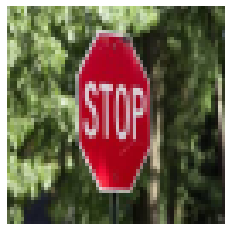

In [8]:
image= 'data/traffic_signs/stop/00000044.jpg'
show_image(image)

In [9]:
pred = predict_proba(model, image)
pred

array([3.6622613e-04, 3.7791513e-05, 9.2366495e-04, 9.9867237e-01],
      dtype=float32)

In [10]:
class_names = ['give_way', 'no_entry', 'priority_road',  'stop']

Verificamos que neste caso, o classificador acerta com um elevado grau de certeza a classe stop. Em seguida, iremos analisar o desempenho do classificador no dataset completo.

## Carregando o dataset de teste criado

Verificando as pastas de cada classe

In [11]:
test_folders= sorted(glob("data/traffic_signs/*/"))
test_folders

['data/traffic_signs/give_way/',
 'data/traffic_signs/no_entry/',
 'data/traffic_signs/priority_road/',
 'data/traffic_signs/stop/']

Confirmando o total de imagens de teste

In [12]:
test_files= sorted(glob("data/traffic_signs/*/*jpg"))
len(test_files)

380

Definindo um vetor (m, 1) representando os labels onde m é o total de imagens de teste

In [13]:
class_names = ['give_way', 'no_entry', 'priority_road',  'stop']
len_class = [71, 123, 64, 122]
labels= np.concatenate((np.zeros(71), np.ones(123), 2*(np.ones(64)), 3*(np.ones(122)) ), axis=0)
len(labels)

380

## Predições no dataset completo

In [14]:
def predict_data(test_x, model):
    """
    Input: 
        test_x: a list of images filenames
        model: a trained model in eval stage
    Output: 
        predicts: a list of predicts
    """

    # the list for storing predictions
    y_preds = []
    
    for file in test_x:
        pred= np.argmax(predict_proba(model,file))
        y_preds.append(pred)
        
    return y_preds

In [15]:
preds= predict_data(test_files,model)

Histrograma representando a quantidade de predições obtidas para cada classe

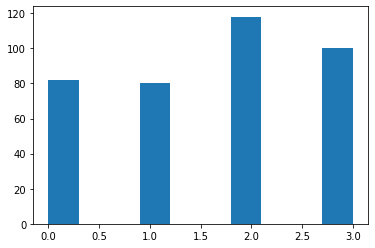

In [16]:
plt.hist(preds,bins=10)
plt.show()

## Métricas

As métricas mais comumente utilizadas em Machine Learning em tarefas de classificacao sao a acuracia, precision, recall e f1_score.

As métricas de desempenho acima citadas sao adequadas para a maioria dos problemas contudo depende de cada aplicacao. 

Ressalta-se que essas métricas sao apresentadas de forma agregada e mostram um quadro incompleto da situação. Para confiar no desempenho de um modelo precisamos inspecionar os resultados em um nível mais granular.

In [17]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

In [18]:
def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

In [19]:
accuracy, precision, recall, f1 = get_metrics(labels, preds)
print("Metricas: acuracia = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

Metricas: acuracia = 0.739, precision = 0.803, recall = 0.739, f1 = 0.745


A construção do modelo é um processo iterativo, onde o objetivo inicial é identificar o que deve ser aprimorado e como aprimorado. As métricas de desempenho que calculamos nos mostram um caminho mas não ajudam a identificar onde o modelo está tendo problemas ou que parte do pipeline precisa ser melhorado. Antes de otimizar o desempenho do modelo ao acaso testando outros modelos, hiperparâmetros ou construindo recursos adicionais, nos próximos itens iremos identificar e abordar os motivos específicos pelos quais o modelo esta falhando.

## Matriz de confusão

Para problemas de classificação, recomenda-se inicialmente verificar a matriz de confusão, cujas linhas representam cada classe verdadeira e as colunas representam as previsões do modelo. Um modelo com previsões perfeitas terá uma matriz de confusão com zeros em todos os lugares, exceto na diagonal que vai do canto superior esquerdo para o canto inferior direito. Vamos visualizar a matriz de confusão do modelo. 

In [20]:
#from https://www.curiousily.com/posts/transfer-learning-for-image-classification-using-torchvision-pytorch-and-python/
def show_confusion_matrix(confusion_matrix, class_names):
  cm = confusion_matrix.copy()
  cell_counts = cm.flatten()
  cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]
  row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]
  cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
  cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])
  df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)
  hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Sign')
  plt.xlabel('Predicted Sign');

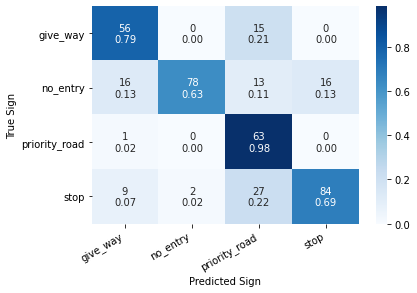

In [21]:
cm = confusion_matrix(labels, preds)
show_confusion_matrix(cm, class_names)

A matriz de confusão acima nos permite ver rapidamente o desempenho do modedo para cada classe. Isso é particularmente útil para conjuntos de dados com muitas classes diferentes ou classes desequilibradas.

Notamos um alto desempenho na classificação da classe priority_road, contudo ao mesmo tempo verificamos que muitos erros das outras classes justamente ocorrem por serem classificadas por esta classe.

Ou seja, para a classe priority_road, a métrica recall é igual a proporção de imagens corretamente classificadas: 63/(1+0+63+0) = 98% 

E o valor de precision é igual 63/(15+13+63+27) = 53%
Esses valores podem ser analisados para cada classe utilizando `classification_report`

In [22]:
print(classification_report(labels, preds, target_names=class_names))

               precision    recall  f1-score   support

     give_way       0.68      0.79      0.73        71
     no_entry       0.97      0.63      0.77       123
priority_road       0.53      0.98      0.69        64
         stop       0.84      0.69      0.76       122

     accuracy                           0.74       380
    macro avg       0.76      0.77      0.74       380
 weighted avg       0.80      0.74      0.75       380



Apesar da matriz de confusão nos mostrar informações mais detalhadas, podemos analisar diretamente as imagens que foram classificadas incorretamente.

## Análise  de erros

Para diagnosticar o desempenho de um modelo, pode ser valioso visualizar previsões individuais. No nosso caso, apresentamos abaixo todas as imagens que o nosso classificador errou.

In [23]:
# Some error analysis
images_pred_incor = []
for x,y in zip(test_files,labels):
    y_hat = np.argmax(predict_proba(model,x))
    if np.abs(y - y_hat ) > 0:
        images_pred_incor.append(x)
        

In [25]:
print('Total de imagens classificadas incorretas:',len(images_pred_incor))

Total de imagens classificadas incorretas: 99


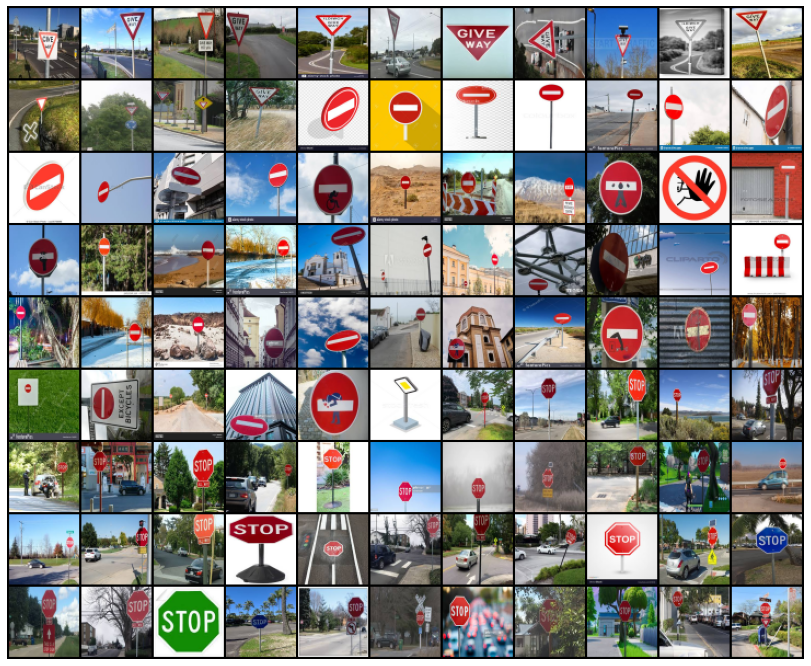

In [26]:
show_sign_grid(images_pred_incor)

A partir da visualização acima, podemos levantar algumas hipóteses:

O classificador apresentou dificuldade em imagens onde a placa de trânsito está representada em uma pequena parte da imagem total.

Alguns erros ocorreram em imagens onde a placa do sinal de trânsito está posicionada em um ângulos diferentes de 90 graus.

Algumas imagens nao são representadas no dataset de treino. Por exemplo, algumas placas de stop estao com a cor verde ou azul.

Contudo a seguir, iremos tentar obter mais insights ao analisar as probabilidades da predição. Podemos identificar as imagens mais desafiadoras ou para as quais o modelo estava menos confiante ao classificar.

# Imagens classificadas com alto grau de confiança

Selecionamos as imagens que foram classificadas corretamente com um grau de certeza maior de 99%.

In [27]:
# Some error analysis
images_pred_top = []
for x,y in zip(test_files,labels):
    pred= predict_proba(model,x)
    y_hat = np.argmax(pred)
    if np.abs(y - y_hat ) == 0:
        prob=np.max(pred)
        if prob > 0.99:
            images_pred_top.append(x)
        

In [28]:
len(images_pred_top)

140

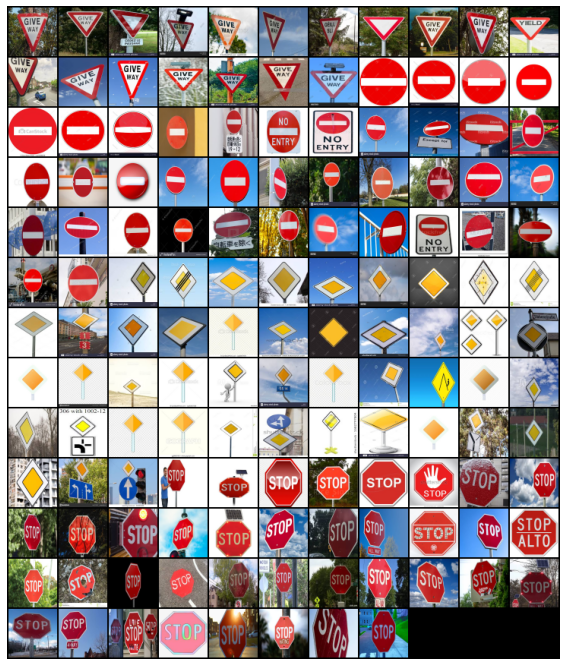

In [29]:
show_sign_grid(images_pred_top)

Ao visualizar esses exemplos, procuramos identificar características que essas imagens possuem em comum que possam explicar o desempenho do modelo. No nosso caso, verificamos que imagens onde a placa de trânsito está mais centralizada são classificadas com facilidade pelo modelo.

## Imagens classificadas incorretamente com um alto grau de confianca

Neste caso, selecionamos as imagens que foram classificadas incorretamente com uma probalidade maior de 90%. Ou seja, são casos onde nosso classificador obteve pior desempenho.

In [30]:
# Some error analysis
images_pred_worst = []
for x,y in zip(test_files,labels):
    pred= predict_proba(model,x)
    y_hat = np.argmax(pred)
    if np.abs(y - y_hat ) > 0:
        prob=np.max(pred)
        if prob > 0.90:
            images_pred_worst.append(x)

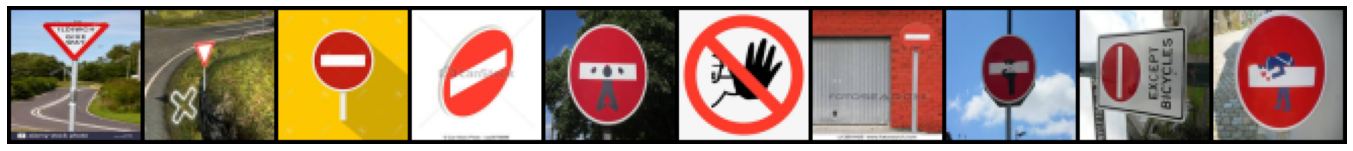

In [31]:
show_sign_grid(images_pred_worst)

O objetivo desta análise é identificar exemplos que diferem significativamente dos dados de treinamento. Por exemplo, a terceira imagem acima ilustrada foi classificada como priority_road, provavelmente pelo fundo amarelo. A partir desta análise, identificamos que a sexta imagem na realidade não representa nenhuma das classes. Esses resultados mostram a importância desse tipo de análise mais detalhada.

## Imagens classificadas corretamente com um grau de incerteza

Neste caso, a visualização consiste em exibir exemplos para os quais o modelo estava menos confiante em suas previsões. Para um modelo de classificação, exemplos incertos são aqueles em que um modelo produz o mais próximo de uma probabilidade igual possível para cada classe.

Espeficicamente, identificamos imagens classificadas corretamente com um valor de probabilidade menor de 60%

In [32]:
# Some error analysis
images_pred_incer = []
for x,y in zip(test_files,labels):
    pred= predict_proba(model,x)
    y_hat = np.argmax(pred)
    if np.abs(y - y_hat ) == 0:
        prob=np.max(pred)
        if prob < 0.6:
            images_pred_incer.append(x)

In [33]:
len(images_pred_incer)

26

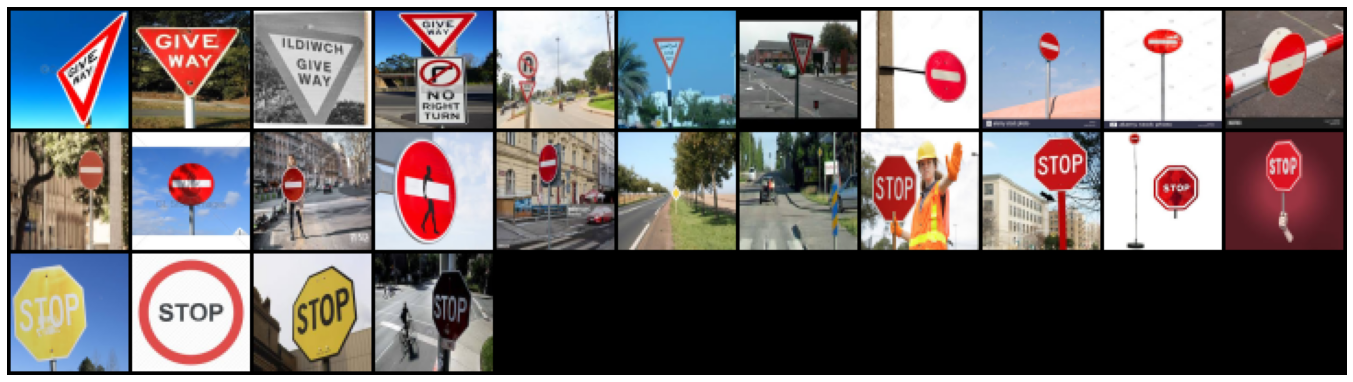

In [34]:
show_sign_grid(images_pred_incer)

Esta analise pode nos ajudar a encontrar lacunas nos dados de treinamento. Os exemplos acima, onde o modelo não tem certeza, mas são claros ao olho humano, geralmente são um sinal de que o modelo não foi exposto a esse tipo de dado em seu conjunto de treinamento. Traçar os principais exemplos incertos para um conjunto de teste pode nos ajudar a identificar os tipos de dados que devem estar presentes no conjunto de treinamento.

## Melhorias no modelo

A partir da analise feita, uma possibilidade que melhoria bastante o desempenho do sistema seria dividir o problema em duas etapas. Na primeira, o objetivo seria encontrar as áreas de interesse (as placas) na imagem e na segunda parte realizar a classificacao. Em Visao Computacional, a primeira etapa é conhecida como detecção de objetos que consiste em desenhar retângulos (chamados de caixas delimitadoras) em torno de áreas de interesse.

As análises feitas mostraram caminhos para melhorar o nosso dataset de teste, como por exemplo a coleta de imagens mais representativas.

Especificamente em relação ao modelo, é uma prática comum iniciar com um modelo pré_treinado utilizando transfer learning. No nosso caso, foi utilizado uma arquitetura Resnet34. Uma possibilidade é treinar um modelo em uma arquitetura mais atual como EfficientNets que nos últimos anos tem demonstrado ser o estado da arte em tarefas de visão computacional. Contudo, o ideal é começar com um modelo simples e verificar se há necessidade de uma arquitetura mais complexa.

+ Read your test dataset, 
+ get the prediction of your test dataset images 
+ based on real and predicted values, generate the metrics that you consider useful and to evaluate the model, explaining why you considered that.
+ Explain the results of the test.  
